<a href="https://colab.research.google.com/github/Taiba528/word-cloud/blob/master/L%26T_loan_defaulter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  Objective:To accurately predict the probability of loanee/borrower defaulting on a vehicle loan .

In [0]:
#Import neccesary libraries
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
from google.colab import files
uploaded=files.upload()

Saving vehicle_train.csv to vehicle_train.csv


In [0]:
#Data access - Reading from a file
df = pd.read_csv("vehicle_train.csv")

In [9]:
df.head()
df.info()
df.shape
df.columns

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,03-08-2018,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,26-09-2018,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,01-08-2018,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,26-10-2018,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,26-09-2018,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

(233154, 41)

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

###Following Information regarding the loan and loanee are provided in the datasets: Loanee Information (Demographic data like age, Identity proof etc.) Loan Information (Disbursal details, loan to value ratio etc.) Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)

In [10]:
#check for missing values
pd.isnull(df).any()
pd.isnull(df).sum()

UniqueID                               False
disbursed_amount                       False
asset_cost                             False
ltv                                    False
branch_id                              False
supplier_id                            False
manufacturer_id                        False
Current_pincode_ID                     False
Date.of.Birth                          False
Employment.Type                         True
DisbursalDate                          False
State_ID                               False
Employee_code_ID                       False
MobileNo_Avl_Flag                      False
Aadhar_flag                            False
PAN_flag                               False
VoterID_flag                           False
Driving_flag                           False
Passport_flag                          False
PERFORM_CNS.SCORE                      False
PERFORM_CNS.SCORE.DESCRIPTION          False
PRI.NO.OF.ACCTS                        False
PRI.ACTIVE

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

### There are missing values in Employment Type.We can neither impute nor ignore this much values,so we will create another category of employment type named as "others"

In [0]:
# Substituting the null values by third category 'others'
df.fillna('others', inplace=True)

### drop some variables which are not going to help in analysis like id's & dates.

In [0]:
#We would like to drop  unnecessary column like "Customer ID" here using drop function.
df=df.drop(['UniqueID','branch_id','supplier_id','manufacturer_id','Current_pincode_ID','Date.of.Birth','State_ID','Employee_code_ID','NO.OF_INQUIRIES','MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag','DisbursalDate'],1)

### PERFORM_CNS.SCORE has 567 distinct values ranging from -1 to 890 with mean value 288.for sake of easy calculation we are replacing all values <300 with -1(minimum value)

In [0]:
df['PERFORM_CNS.SCORE'] = np.where(df['PERFORM_CNS.SCORE']< 300, -1, df['PERFORM_CNS.SCORE'])

### There are some categorical variables which need to be dummy coded for analysis

In [0]:
#dummy coading using the loop structure
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=pd.Categorical( df[col]).codes

In [15]:
df.head()

,disbursed_amount,asset_cost,ltv,Employment.Type,DisbursalDate,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,0,2,1,1,0,0,0,0,-1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,1,68,1,1,0,0,0,0,598,8,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,83,130,0,1
2,53278,61360,89.63,1,0,1,1,0,0,0,0,-1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,1,69,1,1,0,0,0,0,305,11,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,10,133,1,1
4,52378,60300,88.39,1,68,1,1,0,0,0,0,-1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


0    182543
1     50611
Name: loan_default, dtype: int64


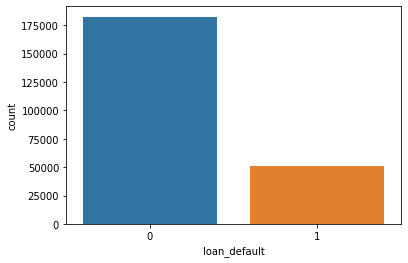

In [18]:
#understand the class distribution
print(df['loan_default'].value_counts())
sns.countplot(x="loan_default", data=df) 

In [19]:
import pandas_profiling
eda_report = pandas_profiling.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [21]:
eda_report

Number of variables,33
Number of observations,233154
Total Missing (%),0.0%
Total size in memory,51.4 MiB
Average record size in memory,231.0 B
Numeric,23
Categorical,0
Boolean,6
Date,0
Text (Unique),0
Rejected,4


### From EDA we got to know  there are 33  variables(after dropping some variables which are not useful in analysis) &	233154 observations.

1.   PRI.CURRENT.BALANCE,PRIMARY.INSTAL.AMT & PRI.SANCTIONED.AMOUNT are highly skewed 
2.   SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS ,SEC.INSTAL.AMT,SEC.CURRENT.BALANCE are highly skewed 





*   PRI.DISBURSED.AMOUNT
This variable is highly correlated with PRI.SANCTIONED.AMOUNT and should be ignored for analysis

Correlation	0.99875

*   SEC.SANCTIONED.AMOUNT
This variable is highly correlated with SEC.CURRENT.BALANCE and should be ignored for analysis

Correlation	0.9292

*   SEC.DISBURSED.AMOUNT
This variable is highly correlated with SEC.SANCTIONED.AMOUNT and should be ignored for analysis

Correlation	0.99965

  


In [22]:
df.describe()

,disbursed_amount,asset_cost,ltv,Employment.Type,DisbursalDate,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
count,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
mean,54356.993528,7.586507e+04,74.746530,0.613144,50.443745,1.0,0.84032,0.075577,0.144943,0.023242,0.002127,288.021231,9.570794,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,0.059081,0.027703,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,28.170518,67.549298,0.206615,0.217071
std,12971.314171,1.894478e+04,11.456636,0.550378,23.431074,0.0,0.36631,0.264320,0.352044,0.150672,0.046074,339.582598,5.087599,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,0.626795,0.316057,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,43.575624,93.339611,0.706498,0.412252
min,13320.000000,3.700000e+04,10.030000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47145.000000,6.571700e+04,68.880000,0.000000,33.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,5.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53803.000000,7.094600e+04,76.800000,1.000000,54.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,13.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60413.000000,7.920175e+04,83.670000,1.000000,71.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,678.000000,13.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,82.000000,137.000000,0.000000,0.000000
max,990572.000000,1.628992e+06,95.000000,2.000000,83.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,890.000000,19.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,191.000000,293.000000,36.000000,1.000000


##Create features and labels for model building

In [54]:
#Create features and labels using Pandas  ‘.drop() ‘
x=df.drop('loan_default',axis=1)
y=df['loan_default']
x.head()
y.head()

,disbursed_amount,asset_cost,ltv,Employment.Type,DisbursalDate,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,50578,58400,89.55,0,2,1,1,0,0,0,0,-1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,1,68,1,1,0,0,0,0,598,8,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,83,130,0
2,53278,61360,89.63,1,0,1,1,0,0,0,0,-1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,1,69,1,1,0,0,0,0,305,11,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,10,133,1
4,52378,60300,88.39,1,68,1,1,0,0,0,0,-1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


0    0
1    1
2    0
3    1
4    1
Name: loan_default, dtype: int64

## Scaling is required here  to standardize the independent features present in the data in a fixed range.

In [24]:
from sklearn.preprocessing import MinMaxScaler
scld = MinMaxScaler(feature_range= (0,1))
arr_scld = scld.fit_transform(x)
df_scld = pd.DataFrame(arr_scld, columns= x.columns) 
df_scld.head()
df_scld.describe()

,disbursed_amount,asset_cost,ltv,Employment.Type,DisbursalDate,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,0.038125,0.013442,0.935860,0.0,0.024096,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.684211,0.000000,0.000000,0.00,0.064710,0.00000,0.00000,0.0,0.0,0.0,0.015698,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000
1,0.034612,0.017934,0.743792,0.5,0.819277,0.0,1.0,0.0,0.0,0.0,0.0,0.672278,0.421053,0.002208,0.006944,0.04,0.064978,0.00005,0.00005,0.0,0.0,0.0,0.015698,0.0,0.0,0.000078,0.0,0.0,0.05,0.434555,0.443686,0.000000
2,0.040888,0.015302,0.936801,0.5,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.684211,0.000000,0.000000,0.00,0.064710,0.00000,0.00000,0.0,0.0,0.0,0.015698,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000
3,0.045222,0.018287,0.923267,0.5,0.831325,0.0,1.0,0.0,0.0,0.0,0.0,0.343434,0.578947,0.006623,0.000000,0.00,0.064710,0.00000,0.00000,0.0,0.0,0.0,0.015698,0.0,0.0,0.000001,0.0,0.0,0.00,0.052356,0.453925,0.027778
4,0.039967,0.014636,0.922208,0.5,0.819277,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.684211,0.000000,0.000000,0.00,0.064710,0.00000,0.00000,0.0,0.0,0.0,0.015698,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.027778


,disbursed_amount,asset_cost,ltv,Employment.Type,DisbursalDate,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
count,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
mean,0.041992,0.024413,0.761640,0.306572,0.607756,0.0,0.84032,0.075577,0.144943,0.023242,0.002127,0.324378,0.503726,0.005388,0.007222,0.006262,0.066318,0.000219,0.000218,0.001136,0.000770,0.000906,0.015846,0.000243,0.000239,0.000511,0.000078,0.010910,0.004874,0.147490,0.230544,0.005739
std,0.013273,0.011900,0.134832,0.275189,0.282302,0.0,0.36631,0.264320,0.352044,0.150672,0.046074,0.381125,0.267768,0.011517,0.013483,0.021951,0.009130,0.002375,0.002378,0.012054,0.008779,0.013885,0.004650,0.006105,0.006086,0.005903,0.003729,0.027289,0.019222,0.228145,0.318565,0.019625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.034612,0.018038,0.692597,0.000000,0.397590,0.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.263158,0.000000,0.000000,0.000000,0.064710,0.000000,0.000000,0.000000,0.000000,0.000000,0.015698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.041425,0.021323,0.785807,0.500000,0.650602,0.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.684211,0.000000,0.000000,0.000000,0.064710,0.000000,0.000000,0.000000,0.000000,0.000000,0.015698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.048189,0.026509,0.866659,0.500000,0.855422,0.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.762065,0.684211,0.006623,0.006944,0.000000,0.065049,0.000063,0.000061,0.000000,0.000000,0.000000,0.015698,0.000000,0.000000,0.000078,0.000000,0.000000,0.000000,0.429319,0.467577,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Splitting the data into the training and test datasets to evaluate the model.

In [25]:
#Split the data into the training and test datasets
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=1)
train_x.shape
train_y.shape
test_x.shape 
test_y.shape    

(163207, 32)

(163207,)

(69947, 32)

(69947,)

## importing some more libraries to present classification accuracy.

In [0]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score


# logistic regression model(classification model)

In [0]:
#Building a Logistic Regression model
from sklearn.linear_model import LogisticRegression
log= LogisticRegression()

### fitting the model on training data

In [29]:
#Fit the model instant on the training data using
log.fit(train_x,train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

###Evaluating the model with test data

In [30]:
# Predict for test data and Generate model Diagnostics
classes = log.predict(test_x)
print(classes.size)
print('Positive cases ',test_y[test_y == 1].shape[0])
print('Negative cases ',test_y[test_y == 0].shape[0])

69947
Positive cases  15147
Negative cases  54800


In [31]:
print(metrics.classification_report(test_y,classes))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54800
           1       0.00      0.00      0.00     15147

    accuracy                           0.78     69947
   macro avg       0.39      0.50      0.44     69947
weighted avg       0.61      0.78      0.69     69947



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Accuracy,precision & recall all are good for '0'(non-defaulter) but for '1' precision & recall  both are 0 which is not desirable for a good model.   
*this problem arises because of imbalance datset as we have very less samples for '1'(defaulter) & our model fail to learn behaviour for this.
we need to use over_sampling algorithm here to increase this sample type."SMOTE" is widely used  for this purpose although we have some other methods also.

In [32]:
#from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
smt = SMOTETomek(ratio='auto')
x_smt, y_smt = smt.fit_sample(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### We are facing Over-sampling problem here as non_dafaulter to defaulter ratio is quiet high.SMOTE (Synthetic Minority Over-Sampling Technique) is used here as the quantity of dafaulter data is insufficient.this sampling technique attempts to balance the data-set by increasing the size of minority samples. Rather than getting rid of majority samples, new minority samples are generated by using this method.

In [33]:
train_x,test_x,train_y, test_y = train_test_split(x_smt, y_smt, test_size = 0.30, random_state =1)
train_x.shape
train_y.shape
test_x.shape
test_y.shape

(236180, 32)

(236180,)

(101220, 32)

(101220,)

In [34]:
#Fit the model instant on the training data using
log.fit(train_x,train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# Predict for test data and Generate model Diagnostics
classes = log.predict(test_x)
print(classes.size)
print('Positive cases ',test_y[test_y == 1].shape[0])
print('Negative cases ',test_y[test_y == 0].shape[0])

101220
Positive cases  50480
Negative cases  50740


In [36]:
print(metrics.classification_report(test_y,classes))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54     50740
           1       0.56      0.65      0.60     50480

    accuracy                           0.57    101220
   macro avg       0.57      0.57      0.57    101220
weighted avg       0.57      0.57      0.57    101220



### After applying 'SMOTE' algorithm model has learnt behaviour of defaulter('1'),

*   precision for'1' is 0.56,which means that out of 100 instances(prediction for defaulters) model was right only 56 times.
*  recall for'1' is 0.65,which means that out of 100 defaulters model was able to identify only 65 defaulters



In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 33 columns):
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
Employment.Type                        233154 non-null int8
DisbursalDate                          233154 non-null int8
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                            233154 non-null int64
PAN_flag                               233154 non-null int64
VoterID_flag                           233154 non-null int64
Driving_flag                           233154 non-null int64
Passport_flag                          233154 non-null int64
PERFORM_CNS.SCORE                      233154 non-null int64
PERFORM_CNS.SCORE.DESCRIPTION          233154 non-null int8
PRI.NO.OF.ACCTS                        233154 non-null int64
PRI.ACTIVE.ACCTS                    

In [0]:
#taking only few numerical variable
df1= df[[ 'disbursed_amount','asset_cost','ltv','PERFORM_CNS.SCORE','NO.OF_INQUIRIES','loan_default']]

In [39]:
df1.columns 
df1.head()

Index(['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE',
       'NO.OF_INQUIRIES', 'loan_default'],
      dtype='object')

,disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,-1,0,0
1,47145,65550,73.23,598,0,1
2,53278,61360,89.63,-1,0,0
3,57513,66113,88.48,305,1,1
4,52378,60300,88.39,-1,1,1


In [40]:
df1.isnull().sum()

disbursed_amount     0
asset_cost           0
ltv                  0
PERFORM_CNS.SCORE    0
NO.OF_INQUIRIES      0
loan_default         0
dtype: int64

In [41]:
x = df1.drop(['loan_default'],axis = 1, inplace = False)
y = df1['loan_default']
x.head()
y.head()

,disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE,NO.OF_INQUIRIES
0,50578,58400,89.55,-1,0
1,47145,65550,73.23,598,0
2,53278,61360,89.63,-1,0
3,57513,66113,88.48,305,1
4,52378,60300,88.39,-1,1


0    0
1    1
2    0
3    1
4    1
Name: loan_default, dtype: int64

In [0]:
from sklearn.preprocessing import MinMaxScaler
scld = MinMaxScaler(feature_range= (0,1))
arr_scld = scld.fit_transform(x)
df_scld = pd.DataFrame(arr_scld, columns= x.columns) 
df_scld.head()
df_scld.describe()

In [43]:
# Find out the number of customers who defaulted vs not defaulted 
print("loan_default ")
df.groupby("loan_default").size()

loan_default 


loan_default
0    182543
1     50611
dtype: int64

In [0]:
#from xgboost import XGBClassifier
#import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score

%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [45]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
dt.fit(train_x,train_y)
classes = dt.predict(test_x)
class_names = 'Default'
auc = metrics.roc_auc_score(test_y,classes)
auc

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

0.732833829528993

In [46]:
print("Accuracy Score")
print(metrics.accuracy_score(test_y,classes ))
print("Precision\Recall metrics")
print(metrics.classification_report(test_y,classes))
print("AUC")
print(metrics.roc_auc_score(test_y,classes))


Accuracy Score
0.733402489626556
Precision\Recall metrics
              precision    recall  f1-score   support

           0       0.66      0.95      0.78     50740
           1       0.92      0.51      0.66     50480

    accuracy                           0.73    101220
   macro avg       0.79      0.73      0.72    101220
weighted avg       0.79      0.73      0.72    101220

AUC
0.732833829528993


confusion Matrix


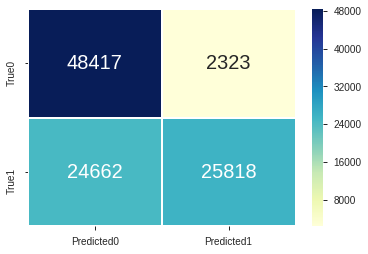

In [47]:
print("confusion Matrix")
cf= metrics.confusion_matrix(test_y,classes)
lbl1 =["Predicted0","Predicted1"]
lbl2 = ["True0","True1"]
sns.heatmap(cf, annot = True, cmap = "YlGnBu",fmt = 'd', xticklabels = lbl1,yticklabels =lbl2, linewidths= 1)
plt.show();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """


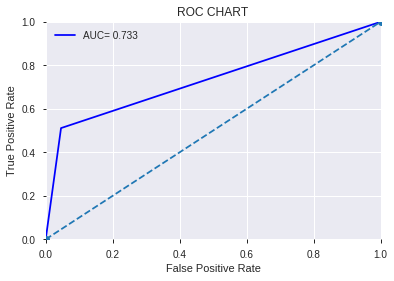

In [48]:
#Drawing ROC Chart
fpr,tpr, th= roc_curve(test_y,classes)
roc_auc = metrics.auc(fpr,tpr)
plt.title("ROC CHART")
plt.plot(fpr,tpr,'b',label = 'AUC= %0.3f' % roc_auc)
plt.legend(loc = 'top right')
plt.plot([0,1],[0,1], 'o--') #drawing dotted line between [0,0] to [1,1]
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

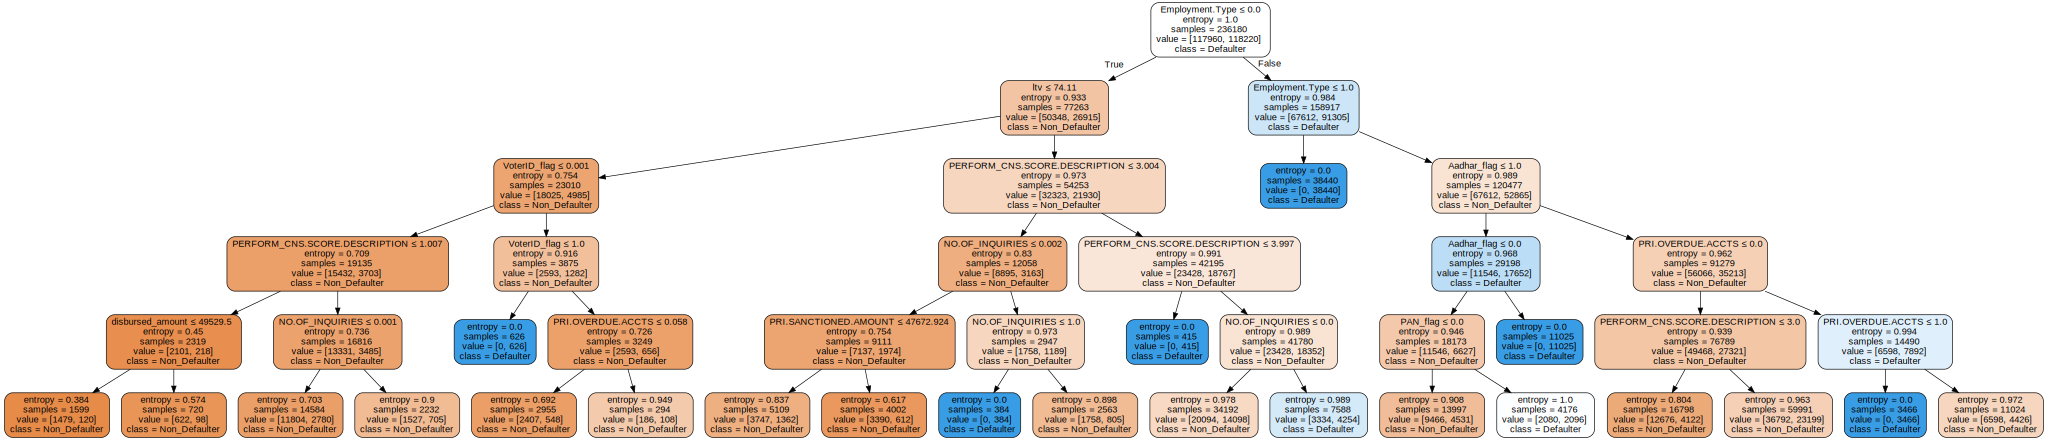

In [58]:
from sklearn import tree
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})
import graphviz
dot_data = tree.export_graphviz(dt, out_file = None, feature_names = x.columns, class_names = ["Non_Defaulter","Defaulter"], filled = True, rounded = True, special_characters = True)
graph = graphviz.Source(dot_data)
graph